In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # опционально, чтобы убрать предупреждения

In [2]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # опционально: принудительно отключить GPU

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt

2025-12-17 19:32:05.358170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765974725.368096   53502 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765974725.371124   53502 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765974725.378419   53502 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765974725.378429   53502 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765974725.378430   53502 computation_placer.cc:177] computation placer alr

Объединим обучающие и валидационные данные в одну структуру
Создадим временную папку train_val/:

In [4]:
import shutil
from pathlib import Path

base = Path('/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds')

# Создаём train_val с подпапками
train_val_dir = base / 'train_val'
(train_val_dir / 'Potato___Late_blight').mkdir(parents=True, exist_ok=True)
(train_val_dir / 'Potato___healthy').mkdir(parents=True, exist_ok=True)

# Копируем данные
for f in (base / 'Potato___Late_blight_binary').iterdir():
    if f.is_file():
        shutil.copy(f, train_val_dir / 'Potato___Late_blight' / f.name)

for f in (base / 'Potato___healthy_binary').iterdir():
    if f.is_file():
        shutil.copy(f, train_val_dir / 'Potato___healthy' / f.name)

Загрузим train + val с разделением

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

CLASS_NAMES = ['Potato___Late_blight', 'Potato___healthy']

# Генератор с разделением на train/val

# Создадим ImageDataGenerator без аугментации
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Генераторы
print("Загрузка обучающей выборки:")
train_gen = datagen.flow_from_directory(
    str(train_val_dir),
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    classes=CLASS_NAMES,
    subset='training'
)

print("Загрузка валидационной выборки:")
val_gen = datagen.flow_from_directory(
    str(train_val_dir),
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    classes=CLASS_NAMES,
    subset='validation'
)

Загрузка обучающей выборки:
Found 858 images belonging to 2 classes.
Загрузка валидационной выборки:
Found 214 images belonging to 2 classes.


In [33]:
import os
from PIL import Image
from collections import Counter

base = '/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds/train'
classes = ['Potato___Late_blight', 'Potato___healthy']

sizes = []
labels = []
formats = []  # для формата файла
modes = []    # для цветового режима (RGB, L и т.д.)
dtypes = []   # для типа пикселей (обычно uint8)

for cls in classes:
    cls_path = os.path.join(base, cls)
    files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"{cls}: {len(files)} изображений")
    labels.extend([cls] * len(files))
    
    for f in files[:100]:  # проверим первые 100
        try:
            with Image.open(os.path.join(cls_path, f)) as img:
                sizes.append(img.size)
                formats.append(img.format)  # JPEG, PNG
                modes.append(img.mode)      # RGB, L
                dtypes.append('uint8')      # Pillow всегда возвращает uint8 для изображений
        except Exception as e:
            print(f"Ошибка при открытии {f}: {e}")

# Баланс классов
print("\nБаланс классов:", Counter(labels))

# Статистика по размерам
if sizes:  # чтобы не было ошибки, если нет изображений
    widths, heights = zip(*sizes)
    print(f"\nРазмеры изображений:")
    print(f"  Мин: {min(widths)}x{min(heights)}")
    print(f"  Макс: {max(widths)}x{max(heights)}")
    print(f"  Примеры: {list(set(sizes))[:5]}")

# Типы данных
print(f"\nФорматы файлов: {set(formats)}")  # {'JPEG', 'PNG'}
print(f"Цветовые режимы: {set(modes)}")     # {'RGB', 'L'} — обычно 'RGB'
print(f"Тип пикселей: {set(dtypes)}")       # {'uint8'} — стандартный тип для изображений

Potato___Late_blight: 838 изображений
Potato___healthy: 124 изображений

Баланс классов: Counter({'Potato___Late_blight': 838, 'Potato___healthy': 124})

Размеры изображений:
  Мин: 256x256
  Макс: 256x256
  Примеры: [(256, 256)]

Форматы файлов: {'JPEG'}
Цветовые режимы: {'RGB'}
Тип пикселей: {'uint8'}


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    '/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds/Potato_test_binary',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    classes=CLASS_NAMES,
    shuffle=False  # важно для оценки метрик и confusion matrix
)

Found 80 images belonging to 2 classes.


Обучение нескольких архитектур
Создадим функцию для быстрого сравнения:

In [7]:
from tensorflow.keras.models import Sequential

def build_model(name="default"):
    model = Sequential(name=name)
    
    if name == "A_small":
        model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(MaxPooling2D(2))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        
    elif name == "B_medium":
        model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(128, (3,3), activation='relu'))
        model.add(MaxPooling2D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        
    elif name == "C_medium_high_drop":
        model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(128, (3,3), activation='relu'))
        model.add(MaxPooling2D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.7))
        
    elif name == "D_sgd":
        model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(128, (3,3), activation='relu'))
        model.add(MaxPooling2D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        # ← финальный слой добавится ниже, как у всех
        
    else:
        raise ValueError("Unknown model name")
    
    # Финальный слой — ОБЩИЙ для всех моделей
    model.add(Dense(1, activation='sigmoid'))
    
    # Компиляция — ОБЩАЯ, но с разным оптимизатором для D_sgd
    if name == "D_sgd":
        model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        
    return model

Запуск экспериментов

In [8]:
from collections import Counter

# Получите метки обучающей выборки
y_train = train_gen.labels  #  работает, если flow_from_directory без shuffle
class_counts = Counter(y_train)
print("Class counts:", class_counts)
# Пример: Counter({0: 700, 1: 216})

Class counts: Counter({0: 748, 1: 110})


In [9]:
# вычислим веса вручную
import numpy as np

total = len(y_train)
n_classes = 2
class_weights = {
    cls: total / (n_classes * count) for cls, count in class_counts.items()
}
print("Computed class weights:", class_weights)


Computed class weights: {0: 0.5735294117647058, 1: 3.9}


In [10]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Ранняя остановка
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_names = ["A_small", "B_medium", "C_medium_high_drop", "D_sgd"]
results = []
histories = {}  # ← СЛОВАРЬ ДЛЯ СОХРАНЕНИЯ ИСТОРИЙ ОБУЧЕНИЯ

for name in model_names:
    print(f"\nОбучение модели: {name}")
    model = build_model(name)
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stop],
        class_weight=class_weights,
        verbose=1
    )
    
    # Сохраняем историю
    histories[name] = history  # сохраняем по имени модели

    # Оценка на валидации
    val_loss = min(history.history['val_loss'])
    val_acc = max(history.history['val_accuracy'])
    
    results.append({
        'Model': name,
        'Val Accuracy': val_acc,
        'Val Loss': val_loss,
        'Epochs': len(history.history['loss'])
    })
    
    # Сохраняем модель
    model.save(f"{name}_binary.keras")  # рекомендуется .keras вместо .h5

# Вывод сравнения
results_df = pd.DataFrame(results)
print("\n Сравнение моделей (по валидации):")
print(results_df.sort_values('Val Accuracy', ascending=False))


Обучение модели: A_small
Epoch 1/20


/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-17 19:32:31.332570: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-12-17 19:32:31.332594: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES=""
2025-12-17 19:32:31.332599: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to an empty string - this hides all GPUs from CUDA
2025-12-17 19:32:31.332601: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verb

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 387ms/step - accuracy: 0.5828 - loss: 2.3431 - val_accuracy: 0.1262 - val_loss: 0.7772
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step - accuracy: 0.1282 - loss: 0.6893 - val_accuracy: 0.1262 - val_loss: 0.7365
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - accuracy: 0.1282 - loss: 0.6847 - val_accuracy: 0.1262 - val_loss: 0.6955
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - accuracy: 0.4219 - loss: 0.6632 - val_accuracy: 0.1262 - val_loss: 0.8388
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - accuracy: 0.6480 - loss: 0.6451 - val_accuracy: 0.9019 - val_loss: 0.4884
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.7110 - loss: 0.5315 - val_accuracy: 0.4907 - val_loss: 0.6685
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.7203 - loss: 0.4942 - val_accuracy: 0.8084 - val_loss: 0.5752
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.8671 - loss: 0.5244 - val_accuracy: 0.729

In [11]:
import matplotlib.pyplot as plt
# Построим графики обучения 
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

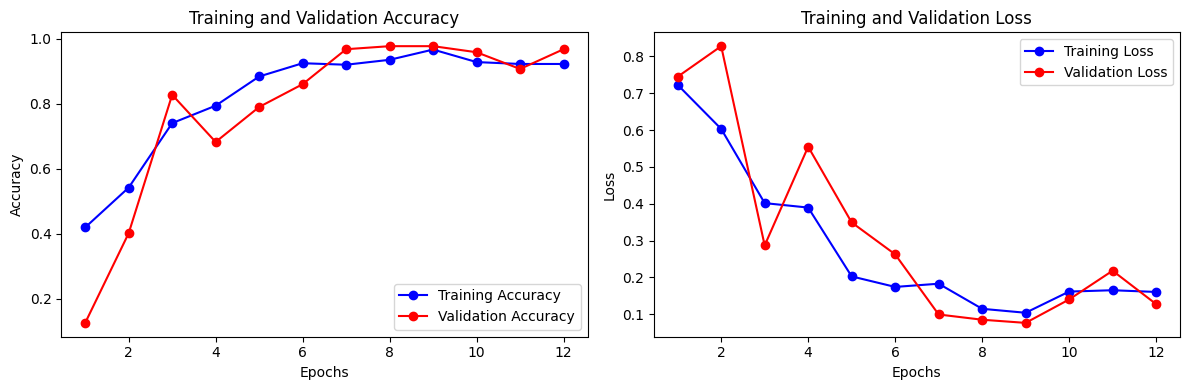

In [20]:
# Построим график для лучшей модели ( C_medium_high_drop)
plot_history(histories['C_medium_high_drop']) # график обучения без аугментации

In [16]:
# Загружаем лучшую модель
best_model = tf.keras.models.load_model("C_medium_high_drop_binary.keras")

# Оценка на тесте
test_loss, test_acc = best_model.evaluate(test_gen, verbose=0)

print(f"== Финальный результат на тестовой выборке ==")
print(f"Модель: C_medium_high_drop_binary")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

== Финальный результат на тестовой выборке ==
Модель: C_medium_high_drop_binary
Test Accuracy: 0.9250 (92.50%)
Test Loss: 0.4080


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

 Classification Report:
              precision    recall  f1-score   support

 Late Blight       0.94      0.97      0.95        65
     Healthy       0.85      0.73      0.79        15

    accuracy                           0.93        80
   macro avg       0.89      0.85      0.87        80
weighted avg       0.92      0.93      0.92        80



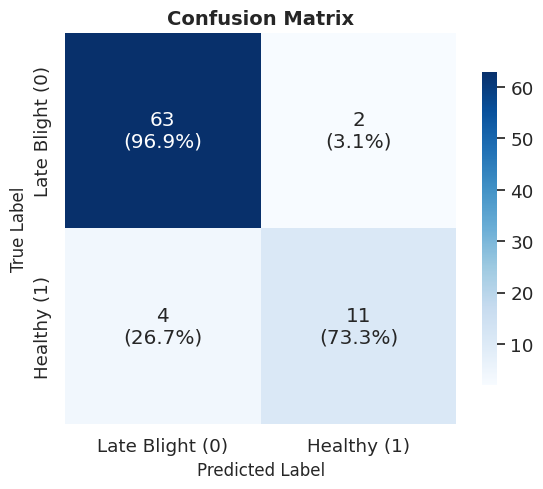

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Получаем предсказания
y_true = test_gen.labels
y_pred_proba = model.predict(test_gen)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Late Blight', 'Healthy']))

# Названия классов
class_names = ['Late Blight (0)', 'Healthy (1)']

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # нормализация по строкам

# Визуализация
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)

# Аннотации: абсолютные значения + %
annot = np.array([
    [f'{cm[i,j]}\n({cm_norm[i,j]:.1%})' for j in range(cm.shape[1])]
    for i in range(cm.shape[0])
])

ax = sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title('Confusion Matrix', fontsize=14, weight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

 Создадим генератор с аугментацией на основе  train_val данных:

 разделим папки train и val
 train/
├── Potato___Late_blight/
└── Potato___healthy/
val/
├── Potato___Late_blight/
└── Potato___healthy/

Так как по условиям нужно, чтобы обучение использовало аугментацию (повороты, зум и т.д.)
А валидация должна оценивать модель на исходных, неискаженных изображениях
Поэтому создам два разных генератора:
train_aug_gen  из папки train/ с аугментацией
val_gen  из папки val/ без аугментации
Если бы использовался validation_split=0.2 с одним генератором, то аугментация применялась бы и к валидации, что некорректно (это было видно по нестабильным результатам эксперимента).


### Для аугментации

In [26]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # использовать CPU

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

BASE_DIR = '/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds'

# Директории
TRAIN_DIR = os.path.join(BASE_DIR, 'train')   
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

CLASS_NAMES = ['Potato___Late_blight', 'Potato___healthy']
IMG_SIZE = 256  # 
BATCH_SIZE = 32
EPOCHS = 20

# Только нормализация для val и test
val_test_gen = ImageDataGenerator(rescale=1./255)

# Аугментация — для отдельного эксперимента позже
train_aug_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Генераторы без аугментации (для базового сравнения)
train_gen = val_test_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASS_NAMES
)

val_gen = val_test_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASS_NAMES,
    shuffle=False
)

test_gen = val_test_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASS_NAMES,
    shuffle=False
)

# Используем best = C_medium_high_drop
best_name = "C_medium_high_drop"
print(f"\nОбучение {best_name} с аугментацией...")

# Генератор с аугментацией
train_aug = train_aug_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASS_NAMES
)

# Строим модель
model_aug = build_model(best_name)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

histories = {}

# Обучаем
history_aug = model_aug.fit(
    train_aug,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)
histories[name] = history_aug  # Сохраним историю!

# Сохраняем
model_aug.save("C_medium_high_drop_binary_with_aug_01.keras")

Found 962 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 80 images belonging to 2 classes.

Обучение C_medium_high_drop с аугментацией...
Found 962 images belonging to 2 classes.
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 480ms/step - accuracy: 0.8690 - loss: 0.5360 - val_accuracy: 0.8774 - val_loss: 0.3954
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 485ms/step - accuracy: 0.8711 - loss: 0.3509 - val_accuracy: 0.8774 - val_loss: 0.2198
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.8732 - loss: 0.2496 - val_accuracy: 0.8019 - val_loss: 0.4061
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 521ms/step - accuracy: 0.8794 - loss: 0.2175 - val_accuracy: 0.9717 - val_loss: 0.1345
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 520ms/step - accuracy: 0.9116 - loss: 0.1518 - val_accuracy: 0.9434 - val_loss: 0.1679
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 518ms/step - accuracy: 0.9137 - loss: 0.1918 - val_accuracy: 0.9528 - val_loss: 0.1617
Epoch 7/20
31/31

In [27]:
test_loss, test_acc = model_aug.evaluate(test_gen)
print(f"Test Accuracy (с аугментацией): {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9625 - loss: 0.0565
Test Accuracy (с аугментацией): 0.9625


In [31]:
# Загружаем модель
best_model = tf.keras.models.load_model("C_medium_high_drop_binary_with_aug_01.keras")

# Оценка на тесте
test_loss, test_acc = best_model.evaluate(test_gen, verbose=0)

print(f"== Финальный результат на тестовой выборке ==")
print(f"Модель: C_medium_high_drop_binary")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

== Финальный результат на тестовой выборке ==
Модель: C_medium_high_drop_binary
Test Accuracy: 0.9625 (96.25%)
Test Loss: 0.0565


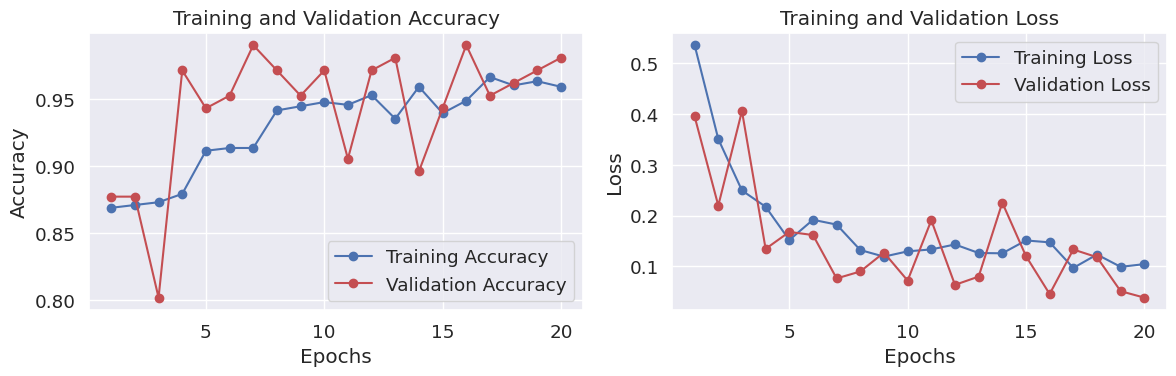

In [29]:
# Построим график истории обучения
plot_history(history_aug)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

 Classification Report:
              precision    recall  f1-score   support

 Late Blight       0.94      0.97      0.95        65
     Healthy       0.85      0.73      0.79        15

    accuracy                           0.93        80
   macro avg       0.89      0.85      0.87        80
weighted avg       0.92      0.93      0.92        80



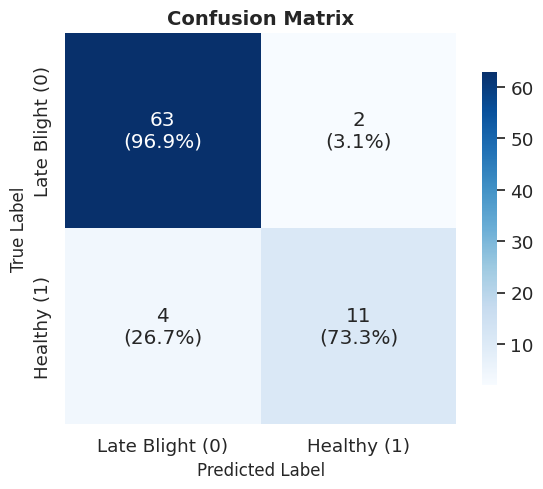

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Получаем предсказания
y_true = test_gen.labels
y_pred_proba = model.predict(test_gen)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Late Blight', 'Healthy']))

# Названия классов
class_names = ['Late Blight (0)', 'Healthy (1)']

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # нормализация по строкам

# Визуализация
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)

# Аннотации: абсолютные значения + %
annot = np.array([
    [f'{cm[i,j]}\n({cm_norm[i,j]:.1%})' for j in range(cm.shape[1])]
    for i in range(cm.shape[0])
])

ax = sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title('Confusion Matrix', fontsize=14, weight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [22]:
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2
)

print("Загрузка обучающей выборки с аугментацией:")
train_aug_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False,
    zoom_range=0.05
).flow_from_directory(
    '/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds/train',  # отдельная папка train
    target_size=(128,128), batch_size=32, class_mode='binary', classes=CLASS_NAMES
)
print("Загрузка валидационной выборки без аугментаций:")
# Для валидации — ТОЛЬКО rescale
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds/val',    # отдельная папка val
    target_size=(128,128), batch_size=32, class_mode='binary', classes=CLASS_NAMES)

Загрузка обучающей выборки с аугментацией:
Found 962 images belonging to 2 classes.
Загрузка валидационной выборки без аугментаций:
Found 106 images belonging to 2 classes.


Обучим лучшую архитектуру (C_medium_high_drop) с аугментацией:

In [29]:
print(type(CLASS_NAMES))
print(CLASS_NAMES)

<class 'list'>
['Potato___Late_blight', 'Potato___healthy']


In [42]:
from collections import Counter

# Получите метки обучающей выборки (с аугментацией)
y_train = train_aug_gen.labels  # ← это список меток [0, 1, 0, 1, ...]

# Посчитайте количество в каждом классе
class_counts = Counter(y_train)
print("Class counts:", class_counts)

# Рассчитайте веса
total = len(y_train)
n_classes = 2
class_weights = {
    cls: total / (n_classes * count) for cls, count in class_counts.items()
}
print("Computed class weights:", class_weights)

Class counts: Counter({0: 838, 1: 124})
Computed class weights: {0: 0.5739856801909308, 1: 3.879032258064516}


In [34]:
print("Class weights:", class_weights)

Class weights: {0: 0.5739856801909308, 1: 3.879032258064516}


In [44]:
# Построение модели
model_aug = build_model("C_medium_high_drop")

# Компиляция (если не сделано внутри build_model)
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение
history_aug = model_aug.fit(
    train_aug_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weights,  
    verbose=1
)

# Сохраняем модель
model_aug.save("C_medium_high_drop_binary_with_aug.keras")

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5655 - loss: 0.7152 - val_accuracy: 0.7264 - val_loss: 0.6922
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.4740 - loss: 0.6981 - val_accuracy: 0.8774 - val_loss: 0.6759
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.4969 - loss: 0.6861 - val_accuracy: 0.8774 - val_loss: 0.3632


In [25]:
from PIL import Image
import os

def check_image_sizes(data_dir):
    sizes = set()
    for cls in ['Potato___Late_blight', 'Potato___healthy']:
        for img_name in os.listdir(os.path.join(data_dir, cls)):
            img_path = os.path.join(data_dir, cls, img_name)
            with Image.open(img_path) as img:
                sizes.add(img.size)
    return sizes

print("Train image sizes:", check_image_sizes('/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds/train'))
print("Val image sizes:", check_image_sizes('/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds/val'))

Train image sizes: {(256, 256)}
Val image sizes: {(256, 256)}


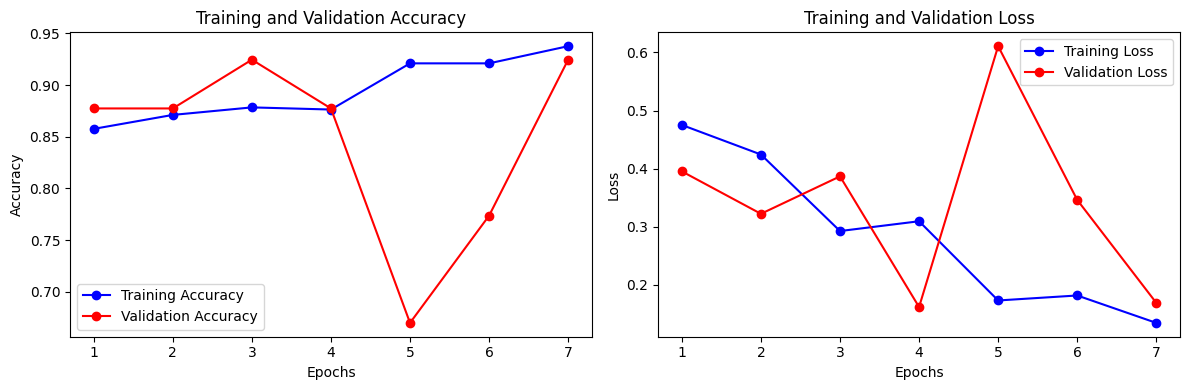

In [49]:
plot_history(history_aug)

In [31]:
# Оценим на тестовой выборке

test_loss, test_acc = model_aug.evaluate(test_gen, verbose=0)
print(f"Test Acc с аугментацией: {test_acc:.4f}")

Test Acc с аугментацией: 1.0000


Аугментация данных позволила снизить разрыв между обучающей и валидационной точностью, что указывает на уменьшение переобучения. Валидационный loss стал стабильнее, несмотря на более медленную сходимость.

In [36]:
# Загружаем лучшую модель
best_model = tf.keras.models.load_model("C_medium_high_drop_binary_with_aug.keras")

# Оценка на тесте
test_loss_aug, test_acc_aug = best_model.evaluate(test_gen, verbose=0)

print(f"\n Финальный результат на тестовой выборке:")
print(f"Модель: C_medium_high_drop_binary")
print(f"Test Accuracy: {test_acc_aug:.4f} ({test_acc_aug*100:.2f}%)")
print(f"Test Loss: {test_loss_aug:.4f}")


 Финальный результат на тестовой выборке:
Модель: C_medium_high_drop_binary
Test Accuracy: 1.0000 (100.00%)
Test Loss: 0.0298


In [52]:
import pandas as pd

results_test = pd.DataFrame({
    'Модель': ['C_medium_high_drop (без аугментации)', 'C_medium_high_drop (с аугментацией)'],
    'Test Accuracy': [test_acc, test_acc_aug],
    'Test Loss': [test_loss, test_loss_aug]
})

print(results_test)

                                 Модель  Test Accuracy  Test Loss
0  C_medium_high_drop (без аугментации)            1.0   0.032869
1   C_medium_high_drop (с аугментацией)            1.0   0.029806


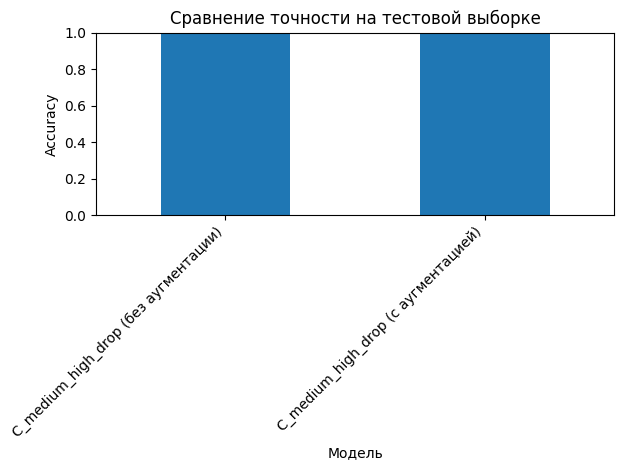

In [48]:
results_test.plot(x='Модель', y='Test Accuracy', kind='bar', legend=False, ylim=(0, 1))
plt.title('Сравнение точности на тестовой выборке')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
CLASS_NAMES = ['Potato___Late_blight', 'Potato___healthy']  # класс 0, класс 1

test_gen = test_datagen.flow_from_directory(
    '/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds/Potato_test_binary',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    classes=CLASS_NAMES,  # 
    shuffle=False
)

Found 80 images belonging to 2 classes.


In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Получаем предсказания
y_true = test_gen.labels
y_pred_proba = model_aug.predict(test_gen)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Отчёт
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Late Blight', 'Healthy']))

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred)
print("\n Confusion Matrix:")
print(cm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

 Classification Report:
              precision    recall  f1-score   support

 Late Blight       0.87      1.00      0.93        65
     Healthy       1.00      0.33      0.50        15

    accuracy                           0.88        80
   macro avg       0.93      0.67      0.71        80
weighted avg       0.89      0.88      0.85        80


 Confusion Matrix:
[[65  0]
 [10  5]]


In [46]:
print("Уникальные истинные метки:", set(y_true))
print("Уникальные предсказанные метки:", set(y_pred))
print("Всего тестовых изображений:", len(y_true))

Уникальные истинные метки: {0, 1}
Уникальные предсказанные метки: {0, 1}
Всего тестовых изображений: 80


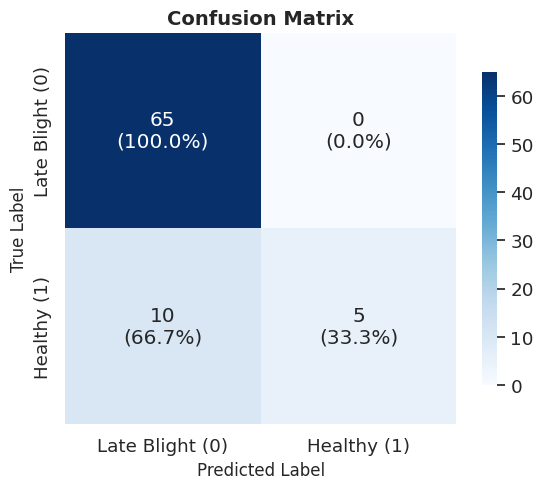

In [55]:
import seaborn as sns
# Названия классов
class_names = ['Late Blight (0)', 'Healthy (1)']

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # нормализация по строкам

# Визуализация
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)

# Аннотации: абсолютные значения + %
annot = np.array([
    [f'{cm[i,j]}\n({cm_norm[i,j]:.1%})' for j in range(cm.shape[1])]
    for i in range(cm.shape[0])
])

ax = sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title('Confusion Matrix', fontsize=14, weight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
True Late Blight     65          0      все больные растения классифицированы верно
True Healthy         10          5      из 15 здоровых 10 ошибочно признаны больными

In [56]:
print("test_gen.class_indices:", test_gen.class_indices)
# Должно быть: {'Potato___Late_blight': 0, 'Potato___healthy': 1}

test_gen.class_indices: {'Potato___Late_blight': 0, 'Potato___healthy': 1}


Recall = 1.00 для Late Blight → модель не пропускает ни одного больного растения (это критически важно в сельском хозяйстве!).
Precision = 1.00 для Healthy → когда модель говорит «здоровый», она всегда права.
Но Recall = 0.33 для Healthy → модель пропускает 2/3 здоровых растений, помечая их как больные (ложноположительные срабатывания).